Problem 1

In [20]:
import torch
from torch import nn

def sigma(x):
    return torch.sigmoid(x)
def sigma_prime(x):
    return sigma(x)*(1-sigma(x))


torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))

In [21]:
# Option 1: directly use PyTorch's autograd feature
for A in A_list:
    A.requires_grad = True
for b in b_list:
    b.requires_grad = True
    
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    
# backward pass in pytorch
loss=torch.square(y-Y_data)/2
loss.backward()

print(A_list[0].grad)

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])


In [22]:
# Option 2: construct a NN model and use backprop
class MLP(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(4,4) for _ in range(L-1)])
        self.linear.append(nn.Linear(4,1))
        for ell in range(L):
            self.linear[ell].weight.data = A_list[ell]
            self.linear[ell].bias.data = b_list[ell].squeeze()
        
    def forward(self, x) :
        x = x.squeeze()
        for ell in range(L-1):
            x = sigma(self.linear[ell](x))
        x = self.linear[-1](x)
        return x

model = MLP()
            
loss = torch.square(model(X_data)-Y_data)/2
loss.backward()

print(model.linear[0].weight.grad)

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])


In [23]:
# Option 3: implement backprop yourself
y_list = [X_data]
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    y_list.append(y)

dA_list = []
db_list = []
dy = y-Y_data  # dloss/dy_L
for ell in reversed(range(L)):

    S = sigma_prime if ell<L-1 else lambda x: torch.ones(x.shape)
    A, b, y = A_list[ell], b_list[ell], y_list[ell]
    
    db = torch.diag(S(A@y + b).view(-1)) @ dy
    dA = torch.diag(S(A@y + b).view(-1)) @ dy @ y.T
    dy = A.T @ torch.diag(S(A@y + b).view(-1)) @ dy

    dA_list.insert(0, dA)
    db_list.insert(0, db)

print(dA_list[0])

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]],
       grad_fn=<MmBackward>)


problem 6

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import transforms
import random
import time
import matplotlib.pyplot as plt

In [3]:
# (Modified version of AlexNet)
class AlexNet(nn.Module):
    def __init__(self, num_class=10):
        super(AlexNet, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6400, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = torch.flatten(output, 1)
        output = self.fc_layer1(output)
        return output

In [4]:
class RandomizedReducedMNIST(Dataset):
    def __init__(self):
        self.MNIST = train_dataset = datasets.MNIST(root='./mnist_data/',
                                                    train=True, 
                                                    transform=transforms.ToTensor(),
                                                    download=True)
        self.MNIST_reduced = Subset(train_dataset, torch.randint(60000, (6000,)))
        self.label = torch.randint(10, (6000,))

    def __len__(self):
        return len(self.MNIST_reduced)
    
    def __getitem__(self, idx):
        image = self.MNIST_reduced[idx][0]
        label = self.label[idx]
        return image, label

In [12]:
train_dataset = RandomizedReducedMNIST()
test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False, 
                              transform=transforms.ToTensor())

learning_rate = 0.1
batch_size = 64
epochs = 150

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
train_accuracy = []
train_loss = []

tick = time.time()
for epoch in range(150):
    print(f"\nEpoch {epoch + 1} / {epochs}")
    
    loss_epoch = 0.0
    correct = 0.0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = loss_function(output, labels)
        loss_epoch += loss

        pred = output.argmax(dim=1)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.size(0)

        loss.backward()

        optimizer.step()
    
    train_loss.append(loss_epoch)
    train_accuracy.append(correct/total)

tock = time.time()
print(f"Total training time: {tock - tick}")


Epoch 1 / 150

Epoch 2 / 150

Epoch 3 / 150

Epoch 4 / 150

Epoch 5 / 150

Epoch 6 / 150

Epoch 7 / 150

Epoch 8 / 150

Epoch 9 / 150

Epoch 10 / 150

Epoch 11 / 150

Epoch 12 / 150

Epoch 13 / 150

Epoch 14 / 150

Epoch 15 / 150

Epoch 16 / 150

Epoch 17 / 150

Epoch 18 / 150

Epoch 19 / 150

Epoch 20 / 150

Epoch 21 / 150

Epoch 22 / 150

Epoch 23 / 150

Epoch 24 / 150

Epoch 25 / 150

Epoch 26 / 150

Epoch 27 / 150

Epoch 28 / 150

Epoch 29 / 150

Epoch 30 / 150

Epoch 31 / 150

Epoch 32 / 150

Epoch 33 / 150

Epoch 34 / 150

Epoch 35 / 150

Epoch 36 / 150

Epoch 37 / 150

Epoch 38 / 150

Epoch 39 / 150

Epoch 40 / 150

Epoch 41 / 150

Epoch 42 / 150

Epoch 43 / 150

Epoch 44 / 150

Epoch 45 / 150

Epoch 46 / 150

Epoch 47 / 150

Epoch 48 / 150

Epoch 49 / 150

Epoch 50 / 150

Epoch 51 / 150

Epoch 52 / 150

Epoch 53 / 150

Epoch 54 / 150

Epoch 55 / 150

Epoch 56 / 150

Epoch 57 / 150

Epoch 58 / 150

Epoch 59 / 150

Epoch 60 / 150

Epoch 61 / 150

Epoch 62 / 150

Epoch 63 / 150



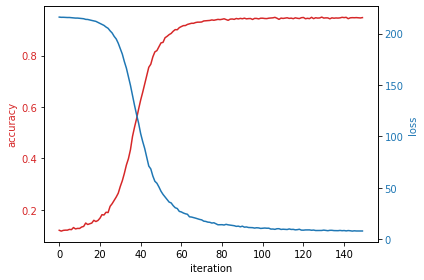

In [16]:
n = len(train_accuracy)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy', color=color)
ax1.plot(range(n), train_accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('loss', color=color)
ax2.plot(range(n), train_loss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [19]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print("Generalization performance: {:.2f}%".format(correct/total * 100))

Generalization performance: 9.67%
